## Wasserstein GAN (WGAN) with Gradient Penalty (GP)

The original [Wasserstein GAN](https://arxiv.org/abs/1701.07875) leverages the
Wasserstein distance to produce a value function that has better theoretical
properties than the value function used in the original GAN paper. WGAN requires
that the discriminator (aka the critic) lie within the space of 1-Lipschitz
functions. The authors proposed the idea of weight clipping to achieve this
constraint. Though weight clipping works, it can be a problematic way to enforce
1-Lipschitz constraint and can cause undesirable behavior, e.g. a very deep WGAN
discriminator (critic) often fails to converge.

The [WGAN-GP](https://arxiv.org/abs/1704.00028) method proposes an
alternative to weight clipping to ensure smooth training. Instead of clipping
the weights, the authors proposed a "gradient penalty" by adding a loss term
that keeps the L2 norm of the discriminator gradients close to 1.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import time
import random

physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


## Constants and hyperparameters

In [3]:
num_channels = 3
num_classes = 25
batch_size = 256
img_size = 64
latent_dim = 128
num_filter = 64
discriminator_in_channels = num_channels + num_classes
generator_in_channels = latent_dim + num_classes

## Load the dataset

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'malevis-train-gan',
    image_size=(img_size,img_size),
    batch_size=batch_size,
)

# Scale the pixel values to [0, 1] range and one-hot encode the labels.
#normalization = layers.experimental.preprocessing.Rescaling(1./255)
# Normalize the pixel values in the [-1, 1] range
normalization = layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1)
train_ds = train_ds.map(lambda x, y: (normalization(x), tf.one_hot(y, num_classes)))

Found 12394 files belonging to 25 classes.


## Create the discriminator (the critic in the original WGAN) and the generator

In [5]:
from tensorflow import keras

discriminator = keras.Sequential(
    [
        layers.InputLayer((img_size, img_size, discriminator_in_channels)),
        layers.Conv2D(num_filter, (5,5), strides=(2,2), padding='same', use_bias=True),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(num_filter*2, (5,5), strides=(2,2), padding='same', use_bias=True),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Conv2D(num_filter*4, (5,5), strides=(2,2), padding='same', use_bias=True),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Conv2D(num_filter*8, (5,5), strides=(2,2), padding='same', use_bias=True),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1),
    ],
    name='discriminator',
)

generator = keras.Sequential(
    [
        layers.InputLayer((generator_in_channels,)),
        layers.Dense(4 * 4 * 256, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((4, 4, 256)),
        layers.UpSampling2D((2,2)),
        layers.Conv2D(num_filter*4, (3,3), strides=(1,1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.UpSampling2D((2,2)),
        layers.Conv2D(num_filter*2, (3,3), strides=(1,1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.UpSampling2D((2,2)),
        layers.Conv2D(num_filter, (3,3), strides=(1,1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.UpSampling2D((2,2)),
        layers.Conv2D(num_channels, (3,3), strides=(1,1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('tanh'),
    ],
    name='generator',
)

discriminator.summary()
generator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        44864     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 256)       

## Create the WGAN-GP model

Now that we have defined our generator and discriminator, it's time to implement
the WGAN-GP model. We will also override the `train_step` for training.

In [6]:
kid_image_size = 75

class KID(keras.metrics.Metric):
    def __init__(self, name="kid", **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean()

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                layers.InputLayer(input_shape=(img_size, img_size, 3)),
                #layers.experimental.preprocessing.Rescaling(255.0),
                layers.experimental.preprocessing.Resizing(height=kid_image_size, width=kid_image_size),
                #layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(
            kernel_generated * (1.0 - tf.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()

In [12]:
class WGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, discriminator_extra_steps=3, gp_weight=10.0):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        self.kid = KID()

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        # Unpack the data
        real_images, one_hot_labels = data
            
        # Get the batch size.
        batch_size = tf.shape(real_images)[0]

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(image_one_hot_labels, repeats=[img_size * img_size])
        image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, img_size, img_size, num_classes))
        
        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Sample random points in the latent vector and concatenate the labels.
            # This is for the generator
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            random_vectors_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)
            
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                # Decode the noise (guided by labels) to fake images.
                fake_images = self.generator(random_vectors_labels, training=True)
                
                # Combine them with real images. Note that we are concatenating the labels
                # with these images here.
                fake_images_and_labels = tf.concat([fake_images, image_one_hot_labels], axis=-1)       
                real_images_and_labels = tf.concat([real_images, image_one_hot_labels], axis=-1)      
                
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images_and_labels, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images_and_labels, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images_and_labels, fake_images_and_labels)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vectors_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_vectors_labels, training=True)
            # Get the discriminator logits for fake images
            generated_images_and_labels = tf.concat([generated_images, image_one_hot_labels], axis=-1)
            gen_img_logits = self.discriminator(generated_images_and_labels, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        
        self.kid.update_state(real_images, fake_images)
        
        return {"d_loss": d_loss, "g_loss": g_loss, self.kid.name: self.kid.result()}    
    
    def plot_images(self, epoch=None, logs=None, num_rows=5, num_cols=5, interval=500):
    # plot random generated images for visual evaluation of generation quality
        if epoch is None or (epoch + 1) % interval == 0 or epoch == 1 or epoch == 5 or epoch == 10 or epoch == 50 or epoch ==100:
            generated_images = []
            for i in range(num_classes):
                label = tf.one_hot([i], num_classes)
                latent_vector = tf.random.normal(shape=(1, latent_dim))
                noise_label = tf.concat([latent_vector, label], 1)
                image = wgan.generator(noise_label, training=False)
                image = (image * 127.5) + 127.5
                image = image[0].numpy()
                image = keras.preprocessing.image.array_to_img(image)
                generated_images.append(image)
        
            plt.figure(figsize=(5,5))
            for row in range(num_rows):
                for col in range(num_cols):
                    index = row * num_cols + col
                    plt.subplot(num_rows, num_cols, index + 1)
                    plt.imshow(generated_images[index])
                    plt.axis("off")
            plt.tight_layout()
            plt.show()
            plt.close()

## Training the WCGAN

Epoch 1/2500
49/49 [==============================] - 86s 1s/step - d_loss: -50.9343 - g_loss: 92.6322 - kid: 0.3659
Epoch 2/2500
49/49 [==============================] - 61s 1s/step - d_loss: -36.8697 - g_loss: 44.4384 - kid: 0.5040


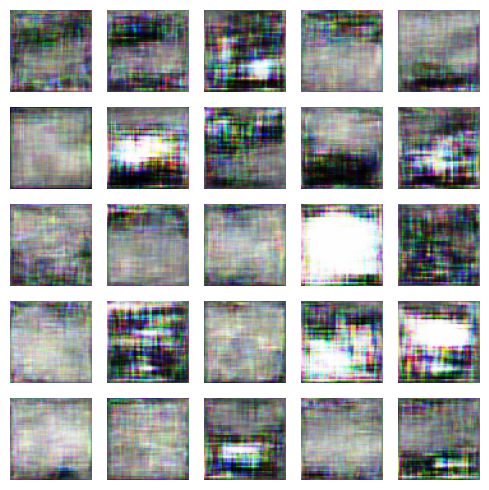

Epoch 3/2500
49/49 [==============================] - 62s 1s/step - d_loss: -31.3434 - g_loss: 16.0417 - kid: 0.4863
Epoch 4/2500
49/49 [==============================] - 62s 1s/step - d_loss: -35.1906 - g_loss: 13.3179 - kid: 0.4866
Epoch 5/2500
49/49 [==============================] - 62s 1s/step - d_loss: -40.3259 - g_loss: 23.1826 - kid: 0.6401
Epoch 6/2500
49/49 [==============================] - 62s 1s/step - d_loss: -41.2753 - g_loss: 28.7777 - kid: 0.8123


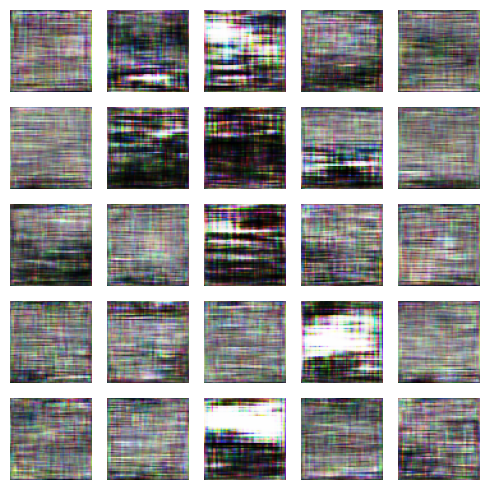

Epoch 7/2500
49/49 [==============================] - 64s 1s/step - d_loss: -40.4555 - g_loss: 34.3087 - kid: 0.8877
Epoch 8/2500
49/49 [==============================] - 62s 1s/step - d_loss: -40.2198 - g_loss: 37.1580 - kid: 0.9566
Epoch 9/2500
49/49 [==============================] - 62s 1s/step - d_loss: -39.8592 - g_loss: 43.2117 - kid: 0.9986
Epoch 10/2500
49/49 [==============================] - 62s 1s/step - d_loss: -39.8067 - g_loss: 48.6353 - kid: 0.9696
Epoch 11/2500
49/49 [==============================] - 62s 1s/step - d_loss: -39.4892 - g_loss: 56.0154 - kid: 0.9074


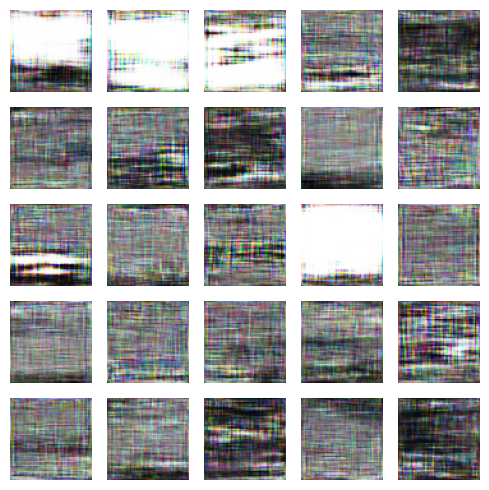

Epoch 12/2500
49/49 [==============================] - 62s 1s/step - d_loss: -39.3078 - g_loss: 56.3093 - kid: 0.8176
Epoch 13/2500
49/49 [==============================] - 62s 1s/step - d_loss: -39.9634 - g_loss: 58.1191 - kid: 0.7801
Epoch 14/2500
49/49 [==============================] - 61s 1s/step - d_loss: -39.3555 - g_loss: 63.3454 - kid: 0.7553
Epoch 15/2500
49/49 [==============================] - 61s 1s/step - d_loss: -39.1454 - g_loss: 68.0731 - kid: 0.6922
Epoch 16/2500
49/49 [==============================] - 61s 1s/step - d_loss: -39.2671 - g_loss: 69.3421 - kid: 0.6585
Epoch 17/2500
49/49 [==============================] - 61s 1s/step - d_loss: -39.0137 - g_loss: 67.3909 - kid: 0.6113
Epoch 18/2500
49/49 [==============================] - 61s 1s/step - d_loss: -38.7673 - g_loss: 63.6545 - kid: 0.5622
Epoch 19/2500
49/49 [==============================] - 61s 1s/step - d_loss: -38.0202 - g_loss: 66.8868 - kid: 0.5420
Epoch 20/2500
49/49 [==============================] - 6

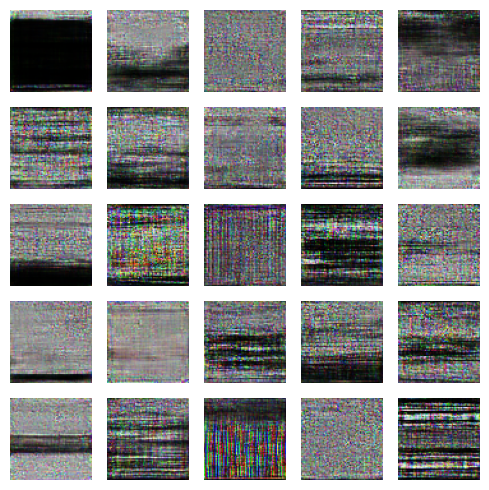

Epoch 52/2500
49/49 [==============================] - 62s 1s/step - d_loss: -26.8933 - g_loss: 30.6612 - kid: 0.0770
Epoch 53/2500
49/49 [==============================] - 62s 1s/step - d_loss: -25.9206 - g_loss: 31.5165 - kid: 0.0739
Epoch 54/2500
49/49 [==============================] - 61s 1s/step - d_loss: -25.6550 - g_loss: 29.4700 - kid: 0.0723
Epoch 55/2500
49/49 [==============================] - 62s 1s/step - d_loss: -25.5422 - g_loss: 27.6359 - kid: 0.0728
Epoch 56/2500
49/49 [==============================] - 61s 1s/step - d_loss: -25.6019 - g_loss: 28.0907 - kid: 0.0743
Epoch 57/2500
49/49 [==============================] - 61s 1s/step - d_loss: -25.3835 - g_loss: 26.9936 - kid: 0.0710
Epoch 58/2500
49/49 [==============================] - 61s 1s/step - d_loss: -25.3438 - g_loss: 25.9343 - kid: 0.0712
Epoch 59/2500
49/49 [==============================] - 61s 1s/step - d_loss: -25.0526 - g_loss: 24.6208 - kid: 0.0708
Epoch 60/2500
49/49 [==============================] - 6

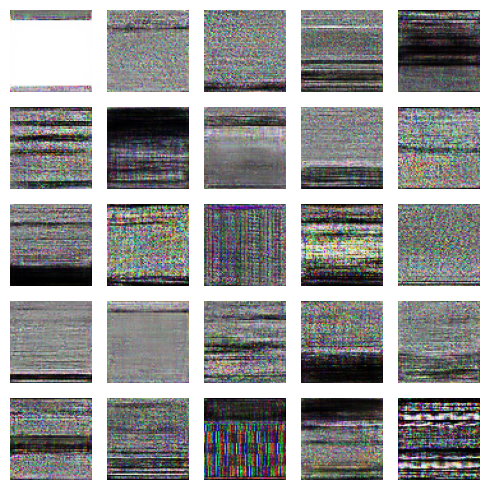

Epoch 102/2500
49/49 [==============================] - 61s 1s/step - d_loss: -20.6980 - g_loss: 10.6105 - kid: 0.0461
Epoch 103/2500
49/49 [==============================] - 61s 1s/step - d_loss: -20.5496 - g_loss: 11.9678 - kid: 0.0457
Epoch 104/2500
49/49 [==============================] - 61s 1s/step - d_loss: -20.9913 - g_loss: 10.4089 - kid: 0.0464
Epoch 105/2500
49/49 [==============================] - 61s 1s/step - d_loss: -20.6283 - g_loss: 11.3654 - kid: 0.0441
Epoch 106/2500
49/49 [==============================] - 61s 1s/step - d_loss: -20.2790 - g_loss: 10.6501 - kid: 0.0445
Epoch 107/2500
49/49 [==============================] - 61s 1s/step - d_loss: -20.6670 - g_loss: 9.7593 - kid: 0.0457
Epoch 108/2500
49/49 [==============================] - 61s 1s/step - d_loss: -20.2176 - g_loss: 10.5464 - kid: 0.0442
Epoch 109/2500
49/49 [==============================] - 61s 1s/step - d_loss: -20.2942 - g_loss: 10.2723 - kid: 0.0430
Epoch 110/2500
49/49 [===========================

49/49 [==============================] - 61s 1s/step - d_loss: -15.9684 - g_loss: 3.5777 - kid: 0.0304
Epoch 172/2500
49/49 [==============================] - 61s 1s/step - d_loss: -15.9779 - g_loss: 2.8268 - kid: 0.0313
Epoch 173/2500
49/49 [==============================] - 61s 1s/step - d_loss: -16.4391 - g_loss: 4.4196 - kid: 0.0321
Epoch 174/2500
49/49 [==============================] - 61s 1s/step - d_loss: -16.2456 - g_loss: 5.4567 - kid: 0.0311
Epoch 175/2500
49/49 [==============================] - 61s 1s/step - d_loss: -15.9946 - g_loss: 2.7754 - kid: 0.0297
Epoch 176/2500
49/49 [==============================] - 61s 1s/step - d_loss: -15.9557 - g_loss: 3.7467 - kid: 0.0299
Epoch 177/2500
49/49 [==============================] - 61s 1s/step - d_loss: -15.5613 - g_loss: 4.1573 - kid: 0.0291
Epoch 178/2500
49/49 [==============================] - 61s 1s/step - d_loss: -15.5563 - g_loss: 1.5976 - kid: 0.0300
Epoch 179/2500
49/49 [==============================] - 61s 1s/step - d

49/49 [==============================] - 61s 1s/step - d_loss: -14.0035 - g_loss: -0.6057 - kid: 0.0236
Epoch 241/2500
49/49 [==============================] - 61s 1s/step - d_loss: -13.7630 - g_loss: -1.8377 - kid: 0.0235
Epoch 242/2500
49/49 [==============================] - 61s 1s/step - d_loss: -13.7594 - g_loss: -2.6942 - kid: 0.0229
Epoch 243/2500
49/49 [==============================] - 61s 1s/step - d_loss: -14.0103 - g_loss: -1.9888 - kid: 0.0241
Epoch 244/2500
49/49 [==============================] - 61s 1s/step - d_loss: -13.7315 - g_loss: -0.1147 - kid: 0.0238
Epoch 245/2500
49/49 [==============================] - 61s 1s/step - d_loss: -13.9845 - g_loss: -2.0096 - kid: 0.0234
Epoch 246/2500
49/49 [==============================] - 61s 1s/step - d_loss: -13.7820 - g_loss: -0.7264 - kid: 0.0228
Epoch 247/2500
49/49 [==============================] - 62s 1s/step - d_loss: -13.5117 - g_loss: -1.3075 - kid: 0.0228
Epoch 248/2500
49/49 [==============================] - 61s 1s/

49/49 [==============================] - 61s 1s/step - d_loss: -12.3245 - g_loss: -0.6432 - kid: 0.0216
Epoch 310/2500
49/49 [==============================] - 61s 1s/step - d_loss: -12.3163 - g_loss: 0.2764 - kid: 0.0210
Epoch 311/2500
49/49 [==============================] - 61s 1s/step - d_loss: -12.1874 - g_loss: -0.6918 - kid: 0.0202
Epoch 312/2500
49/49 [==============================] - 61s 1s/step - d_loss: -12.6312 - g_loss: -5.0104e-04 - kid: 0.0208
Epoch 313/2500
49/49 [==============================] - 61s 1s/step - d_loss: -12.4305 - g_loss: -2.5455 - kid: 0.0212
Epoch 314/2500
49/49 [==============================] - 61s 1s/step - d_loss: -12.3740 - g_loss: -2.9484 - kid: 0.0209
Epoch 315/2500
49/49 [==============================] - 61s 1s/step - d_loss: -12.8244 - g_loss: -1.6271 - kid: 0.0213
Epoch 316/2500
49/49 [==============================] - 61s 1s/step - d_loss: -12.4791 - g_loss: -3.3324 - kid: 0.0210
Epoch 317/2500
49/49 [==============================] - 61s 

49/49 [==============================] - 61s 1s/step - d_loss: -11.4416 - g_loss: -1.6073 - kid: 0.0179
Epoch 378/2500
49/49 [==============================] - 61s 1s/step - d_loss: -11.5659 - g_loss: -3.5878 - kid: 0.0191
Epoch 379/2500
49/49 [==============================] - 62s 1s/step - d_loss: -11.3160 - g_loss: -2.8069 - kid: 0.0187
Epoch 380/2500
49/49 [==============================] - 61s 1s/step - d_loss: -11.4787 - g_loss: -1.0919 - kid: 0.0186
Epoch 381/2500
49/49 [==============================] - 61s 1s/step - d_loss: -11.1836 - g_loss: -2.1269 - kid: 0.0179
Epoch 382/2500
49/49 [==============================] - 61s 1s/step - d_loss: -11.4947 - g_loss: -1.8804 - kid: 0.0183
Epoch 383/2500
49/49 [==============================] - 61s 1s/step - d_loss: -11.3505 - g_loss: -3.8255 - kid: 0.0189
Epoch 384/2500
49/49 [==============================] - 61s 1s/step - d_loss: -11.4514 - g_loss: -5.4127 - kid: 0.0177
Epoch 385/2500
49/49 [==============================] - 61s 1s/

Epoch 446/2500
49/49 [==============================] - 61s 1s/step - d_loss: -10.7900 - g_loss: -3.4321 - kid: 0.0164
Epoch 447/2500
49/49 [==============================] - 61s 1s/step - d_loss: -10.7540 - g_loss: -1.5438 - kid: 0.0168
Epoch 448/2500
49/49 [==============================] - 61s 1s/step - d_loss: -10.7945 - g_loss: -1.3610 - kid: 0.0165
Epoch 449/2500
49/49 [==============================] - 61s 1s/step - d_loss: -10.7666 - g_loss: -1.3134 - kid: 0.0159
Epoch 450/2500
49/49 [==============================] - 61s 1s/step - d_loss: -10.6491 - g_loss: -2.7278 - kid: 0.0163
Epoch 451/2500
49/49 [==============================] - 61s 1s/step - d_loss: -10.7801 - g_loss: -2.7928 - kid: 0.0174
Epoch 452/2500
49/49 [==============================] - 61s 1s/step - d_loss: -10.8189 - g_loss: -2.5962 - kid: 0.0162
Epoch 453/2500
49/49 [==============================] - 61s 1s/step - d_loss: -10.6879 - g_loss: -3.9053 - kid: 0.0157
Epoch 454/2500
49/49 [==========================

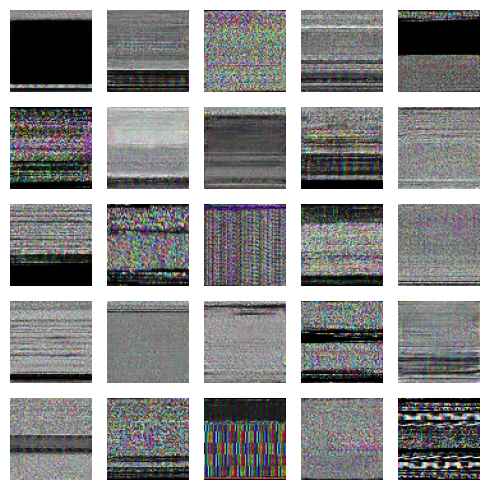

Epoch 501/2500
49/49 [==============================] - 61s 1s/step - d_loss: -10.2476 - g_loss: -4.4759 - kid: 0.0148
Epoch 502/2500
49/49 [==============================] - 62s 1s/step - d_loss: -10.3653 - g_loss: -3.1073 - kid: 0.0156
Epoch 503/2500
49/49 [==============================] - 61s 1s/step - d_loss: -10.0478 - g_loss: -3.6932 - kid: 0.0153
Epoch 504/2500
49/49 [==============================] - 62s 1s/step - d_loss: -10.1145 - g_loss: -4.7134 - kid: 0.0148
Epoch 505/2500
49/49 [==============================] - 61s 1s/step - d_loss: -10.2613 - g_loss: -2.1070 - kid: 0.0155
Epoch 506/2500
49/49 [==============================] - 61s 1s/step - d_loss: -10.3806 - g_loss: -3.8028 - kid: 0.0150
Epoch 507/2500
49/49 [==============================] - 61s 1s/step - d_loss: -10.2437 - g_loss: -4.3908 - kid: 0.0149
Epoch 508/2500
49/49 [==============================] - 61s 1s/step - d_loss: -10.3970 - g_loss: -4.0561 - kid: 0.0148
Epoch 509/2500
49/49 [==========================

49/49 [==============================] - 62s 1s/step - d_loss: -9.8549 - g_loss: -1.6260 - kid: 0.0147
Epoch 571/2500
49/49 [==============================] - 62s 1s/step - d_loss: -9.8510 - g_loss: -2.1551 - kid: 0.0136
Epoch 572/2500
49/49 [==============================] - 62s 1s/step - d_loss: -9.7540 - g_loss: -3.6714 - kid: 0.0142
Epoch 573/2500
49/49 [==============================] - 62s 1s/step - d_loss: -9.6850 - g_loss: -3.4933 - kid: 0.0135
Epoch 574/2500
49/49 [==============================] - 62s 1s/step - d_loss: -9.6008 - g_loss: -3.3230 - kid: 0.0138
Epoch 575/2500
49/49 [==============================] - 62s 1s/step - d_loss: -9.7386 - g_loss: -3.7200 - kid: 0.0141
Epoch 576/2500
49/49 [==============================] - 62s 1s/step - d_loss: -9.6644 - g_loss: -4.2209 - kid: 0.0139
Epoch 577/2500
49/49 [==============================] - 62s 1s/step - d_loss: -9.6791 - g_loss: -4.3538 - kid: 0.0136
Epoch 578/2500
49/49 [==============================] - 62s 1s/step - d

49/49 [==============================] - 61s 1s/step - d_loss: -9.2332 - g_loss: -3.5740 - kid: 0.0134
Epoch 640/2500
49/49 [==============================] - 61s 1s/step - d_loss: -9.3029 - g_loss: -6.6158 - kid: 0.0135
Epoch 641/2500
49/49 [==============================] - 61s 1s/step - d_loss: -9.3653 - g_loss: -5.0968 - kid: 0.0138
Epoch 642/2500
49/49 [==============================] - 61s 1s/step - d_loss: -9.4609 - g_loss: -5.3866 - kid: 0.0137
Epoch 643/2500
49/49 [==============================] - 61s 1s/step - d_loss: -9.3339 - g_loss: -5.1211 - kid: 0.0128
Epoch 644/2500
49/49 [==============================] - 61s 1s/step - d_loss: -9.1576 - g_loss: -3.6521 - kid: 0.0130
Epoch 645/2500
49/49 [==============================] - 61s 1s/step - d_loss: -9.3655 - g_loss: -5.0564 - kid: 0.0139
Epoch 646/2500
49/49 [==============================] - 61s 1s/step - d_loss: -9.2697 - g_loss: -4.3041 - kid: 0.0131
Epoch 647/2500
49/49 [==============================] - 61s 1s/step - d

49/49 [==============================] - 61s 1s/step - d_loss: -9.0579 - g_loss: -3.2791 - kid: 0.0131
Epoch 709/2500
49/49 [==============================] - 62s 1s/step - d_loss: -8.9547 - g_loss: -3.3313 - kid: 0.0125
Epoch 710/2500
49/49 [==============================] - 61s 1s/step - d_loss: -9.1104 - g_loss: -2.3095 - kid: 0.0123
Epoch 711/2500
49/49 [==============================] - 61s 1s/step - d_loss: -9.0603 - g_loss: -4.2887 - kid: 0.0124
Epoch 712/2500
49/49 [==============================] - 61s 1s/step - d_loss: -8.9643 - g_loss: -4.7313 - kid: 0.0124
Epoch 713/2500
49/49 [==============================] - 61s 1s/step - d_loss: -8.8431 - g_loss: -5.2602 - kid: 0.0126
Epoch 714/2500
49/49 [==============================] - 61s 1s/step - d_loss: -9.0642 - g_loss: -4.9195 - kid: 0.0121
Epoch 715/2500
49/49 [==============================] - 61s 1s/step - d_loss: -9.0053 - g_loss: -4.1321 - kid: 0.0123
Epoch 716/2500
49/49 [==============================] - 61s 1s/step - d

49/49 [==============================] - 62s 1s/step - d_loss: -8.7314 - g_loss: -3.1074 - kid: 0.0131
Epoch 778/2500
49/49 [==============================] - 61s 1s/step - d_loss: -8.8147 - g_loss: -2.5838 - kid: 0.0131
Epoch 779/2500
49/49 [==============================] - 61s 1s/step - d_loss: -8.6439 - g_loss: -2.6754 - kid: 0.0124
Epoch 780/2500
49/49 [==============================] - 61s 1s/step - d_loss: -8.7400 - g_loss: -2.4937 - kid: 0.0132
Epoch 781/2500
49/49 [==============================] - 61s 1s/step - d_loss: -8.7039 - g_loss: -2.7710 - kid: 0.0123
Epoch 782/2500
49/49 [==============================] - 61s 1s/step - d_loss: -8.6491 - g_loss: -3.4159 - kid: 0.0121
Epoch 783/2500
49/49 [==============================] - 61s 1s/step - d_loss: -8.6462 - g_loss: -3.5939 - kid: 0.0123
Epoch 784/2500
49/49 [==============================] - 61s 1s/step - d_loss: -8.7566 - g_loss: -4.0301 - kid: 0.0115
Epoch 785/2500
49/49 [==============================] - 61s 1s/step - d

49/49 [==============================] - 61s 1s/step - d_loss: -8.3754 - g_loss: -2.6506 - kid: 0.0122
Epoch 847/2500
49/49 [==============================] - 61s 1s/step - d_loss: -8.4094 - g_loss: -2.2660 - kid: 0.0119
Epoch 848/2500
49/49 [==============================] - 61s 1s/step - d_loss: -8.4878 - g_loss: -3.6842 - kid: 0.0120
Epoch 849/2500
49/49 [==============================] - 61s 1s/step - d_loss: -8.6983 - g_loss: -3.1312 - kid: 0.0121
Epoch 850/2500
49/49 [==============================] - 61s 1s/step - d_loss: -8.5698 - g_loss: -4.6418 - kid: 0.0125
Epoch 851/2500
49/49 [==============================] - 61s 1s/step - d_loss: -8.5406 - g_loss: -4.2122 - kid: 0.0116
Epoch 852/2500
49/49 [==============================] - 61s 1s/step - d_loss: -8.3549 - g_loss: -4.2759 - kid: 0.0119
Epoch 853/2500
49/49 [==============================] - 61s 1s/step - d_loss: -8.4041 - g_loss: -5.2068 - kid: 0.0121
Epoch 854/2500
49/49 [==============================] - 61s 1s/step - d

49/49 [==============================] - 61s 1s/step - d_loss: -8.1956 - g_loss: -3.8036 - kid: 0.0120
Epoch 916/2500
49/49 [==============================] - 62s 1s/step - d_loss: -8.3027 - g_loss: -3.5423 - kid: 0.0118
Epoch 917/2500
49/49 [==============================] - 61s 1s/step - d_loss: -8.2442 - g_loss: -5.0987 - kid: 0.0121
Epoch 918/2500
49/49 [==============================] - 62s 1s/step - d_loss: -8.4466 - g_loss: -5.0041 - kid: 0.0120
Epoch 919/2500
49/49 [==============================] - 62s 1s/step - d_loss: -8.2558 - g_loss: -5.4918 - kid: 0.0120
Epoch 920/2500
49/49 [==============================] - 62s 1s/step - d_loss: -8.2552 - g_loss: -5.8451 - kid: 0.0119
Epoch 921/2500
49/49 [==============================] - 61s 1s/step - d_loss: -8.3847 - g_loss: -6.3911 - kid: 0.0113
Epoch 922/2500
49/49 [==============================] - 61s 1s/step - d_loss: -8.3437 - g_loss: -5.9435 - kid: 0.0123
Epoch 923/2500
49/49 [==============================] - 62s 1s/step - d

49/49 [==============================] - 61s 1s/step - d_loss: -8.2984 - g_loss: -5.7032 - kid: 0.0118
Epoch 985/2500
49/49 [==============================] - 62s 1s/step - d_loss: -8.1038 - g_loss: -7.5764 - kid: 0.0115
Epoch 986/2500
49/49 [==============================] - 62s 1s/step - d_loss: -8.1914 - g_loss: -7.8959 - kid: 0.0122
Epoch 987/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.9359 - g_loss: -5.1521 - kid: 0.0113
Epoch 988/2500
49/49 [==============================] - 62s 1s/step - d_loss: -8.1025 - g_loss: -4.4829 - kid: 0.0112
Epoch 989/2500
49/49 [==============================] - 62s 1s/step - d_loss: -8.3745 - g_loss: -3.8676 - kid: 0.0122
Epoch 990/2500
49/49 [==============================] - 62s 1s/step - d_loss: -8.2243 - g_loss: -5.3049 - kid: 0.0117
Epoch 991/2500
49/49 [==============================] - 61s 1s/step - d_loss: -8.2259 - g_loss: -5.2899 - kid: 0.0111
Epoch 992/2500
49/49 [==============================] - 62s 1s/step - d

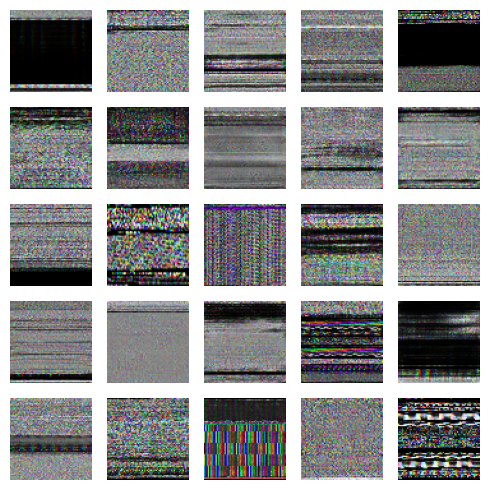

Epoch 1001/2500
49/49 [==============================] - 62s 1s/step - d_loss: -8.1723 - g_loss: -5.8814 - kid: 0.0114
Epoch 1002/2500
49/49 [==============================] - 62s 1s/step - d_loss: -8.2579 - g_loss: -6.3790 - kid: 0.0114
Epoch 1003/2500
49/49 [==============================] - 62s 1s/step - d_loss: -8.1221 - g_loss: -6.4205 - kid: 0.0114
Epoch 1004/2500
49/49 [==============================] - 62s 1s/step - d_loss: -8.0826 - g_loss: -5.6660 - kid: 0.0118
Epoch 1005/2500
49/49 [==============================] - 62s 1s/step - d_loss: -8.1412 - g_loss: -5.4830 - kid: 0.0114
Epoch 1006/2500
49/49 [==============================] - 62s 1s/step - d_loss: -8.1781 - g_loss: -4.1401 - kid: 0.0122
Epoch 1007/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.8877 - g_loss: -6.2749 - kid: 0.0122
Epoch 1008/2500
49/49 [==============================] - 62s 1s/step - d_loss: -8.2466 - g_loss: -7.4514 - kid: 0.0118
Epoch 1009/2500
49/49 [=========================

49/49 [==============================] - 62s 1s/step - d_loss: -7.9061 - g_loss: -4.9403 - kid: 0.0116
Epoch 1070/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.9008 - g_loss: -6.7950 - kid: 0.0114
Epoch 1071/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.9072 - g_loss: -6.0614 - kid: 0.0111
Epoch 1072/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.8626 - g_loss: -6.3063 - kid: 0.0119
Epoch 1073/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.9524 - g_loss: -7.2536 - kid: 0.0114
Epoch 1074/2500
49/49 [==============================] - 62s 1s/step - d_loss: -8.0244 - g_loss: -5.5454 - kid: 0.0117
Epoch 1075/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.9472 - g_loss: -6.9820 - kid: 0.0110
Epoch 1076/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.9642 - g_loss: -6.7162 - kid: 0.0119
Epoch 1077/2500
49/49 [==============================] - 62s 1s/

49/49 [==============================] - 62s 1s/step - d_loss: -7.6885 - g_loss: -5.5738 - kid: 0.0113
Epoch 1138/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.6575 - g_loss: -4.9537 - kid: 0.0109
Epoch 1139/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.8071 - g_loss: -4.0266 - kid: 0.0114
Epoch 1140/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.7696 - g_loss: -3.5301 - kid: 0.0107
Epoch 1141/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.6804 - g_loss: -4.2230 - kid: 0.0110
Epoch 1142/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.6685 - g_loss: -5.3727 - kid: 0.0111
Epoch 1143/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.7852 - g_loss: -6.0461 - kid: 0.0111
Epoch 1144/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.8635 - g_loss: -8.6278 - kid: 0.0108
Epoch 1145/2500
49/49 [==============================] - 62s 1s/

Epoch 1206/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.8948 - g_loss: -7.8887 - kid: 0.0110
Epoch 1207/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.6667 - g_loss: -7.3672 - kid: 0.0104
Epoch 1208/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.6384 - g_loss: -6.7255 - kid: 0.0119
Epoch 1209/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.8549 - g_loss: -6.4788 - kid: 0.0110
Epoch 1210/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.6785 - g_loss: -6.5233 - kid: 0.0111
Epoch 1211/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.6052 - g_loss: -6.8285 - kid: 0.0114
Epoch 1212/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.6873 - g_loss: -8.7454 - kid: 0.0110
Epoch 1213/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.7793 - g_loss: -8.2209 - kid: 0.0115
Epoch 1214/2500
49/49 [=========================

49/49 [==============================] - 62s 1s/step - d_loss: -7.4382 - g_loss: -8.2653 - kid: 0.0100
Epoch 1275/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.5787 - g_loss: -7.7014 - kid: 0.0108
Epoch 1276/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.6082 - g_loss: -6.6052 - kid: 0.0109
Epoch 1277/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.5676 - g_loss: -6.7090 - kid: 0.0108
Epoch 1278/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.6755 - g_loss: -6.3840 - kid: 0.0103
Epoch 1279/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.5692 - g_loss: -7.1269 - kid: 0.0107
Epoch 1280/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.6197 - g_loss: -8.2692 - kid: 0.0106
Epoch 1281/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.5474 - g_loss: -8.6512 - kid: 0.0101
Epoch 1282/2500
49/49 [==============================] - 62s 1s/

49/49 [==============================] - 62s 1s/step - d_loss: -7.4656 - g_loss: -6.2232 - kid: 0.0103
Epoch 1343/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.4562 - g_loss: -7.4323 - kid: 0.0107
Epoch 1344/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.6043 - g_loss: -7.3343 - kid: 0.0105
Epoch 1345/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.7005 - g_loss: -6.8177 - kid: 0.0114
Epoch 1346/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.6098 - g_loss: -6.1460 - kid: 0.0105
Epoch 1347/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.4744 - g_loss: -6.7375 - kid: 0.0104
Epoch 1348/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.5148 - g_loss: -4.5829 - kid: 0.0102
Epoch 1349/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.5430 - g_loss: -4.9785 - kid: 0.0102
Epoch 1350/2500
49/49 [==============================] - 62s 1s/

49/49 [==============================] - 62s 1s/step - d_loss: -7.3215 - g_loss: -7.9020 - kid: 0.0100
Epoch 1411/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.4709 - g_loss: -7.2020 - kid: 0.0098
Epoch 1412/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.4648 - g_loss: -8.8574 - kid: 0.0099
Epoch 1413/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.4409 - g_loss: -7.1800 - kid: 0.0095
Epoch 1414/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.2945 - g_loss: -7.0764 - kid: 0.0101
Epoch 1415/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.3488 - g_loss: -6.4245 - kid: 0.0102
Epoch 1416/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.5228 - g_loss: -5.9897 - kid: 0.0104
Epoch 1417/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.4018 - g_loss: -6.7404 - kid: 0.0103
Epoch 1418/2500
49/49 [==============================] - 62s 1s/

Epoch 1479/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.3384 - g_loss: -7.7508 - kid: 0.0102
Epoch 1480/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.4068 - g_loss: -5.8531 - kid: 0.0104
Epoch 1481/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.5298 - g_loss: -8.2322 - kid: 0.0095
Epoch 1482/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.1973 - g_loss: -6.4946 - kid: 0.0092
Epoch 1483/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.3627 - g_loss: -5.0971 - kid: 0.0104
Epoch 1484/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.3426 - g_loss: -5.7767 - kid: 0.0102
Epoch 1485/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.2465 - g_loss: -8.4453 - kid: 0.0097
Epoch 1486/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.3590 - g_loss: -9.0198 - kid: 0.0099
Epoch 1487/2500
49/49 [=========================

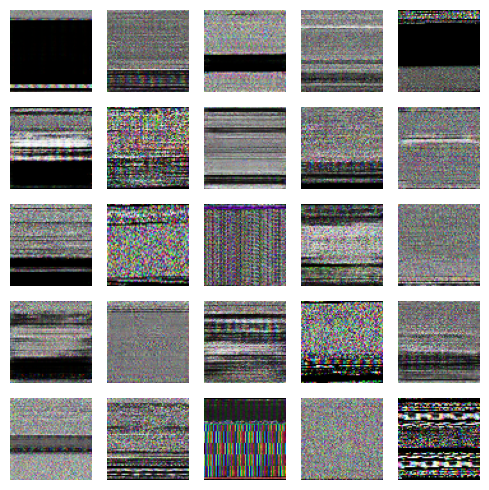

Epoch 1501/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.2666 - g_loss: -7.1703 - kid: 0.0097
Epoch 1502/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.3773 - g_loss: -7.2285 - kid: 0.0093
Epoch 1503/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.3207 - g_loss: -4.3680 - kid: 0.0095
Epoch 1504/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.4617 - g_loss: -5.6285 - kid: 0.0099
Epoch 1505/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.2291 - g_loss: -7.7380 - kid: 0.0098
Epoch 1506/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.3859 - g_loss: -6.8266 - kid: 0.0099
Epoch 1507/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.2450 - g_loss: -5.5118 - kid: 0.0098
Epoch 1508/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.3006 - g_loss: -6.2122 - kid: 0.0095
Epoch 1509/2500
49/49 [=========================

49/49 [==============================] - 62s 1s/step - d_loss: -7.3884 - g_loss: -8.3505 - kid: 0.0095
Epoch 1570/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.4499 - g_loss: -7.6748 - kid: 0.0100
Epoch 1571/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.4136 - g_loss: -6.5263 - kid: 0.0098
Epoch 1572/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.2650 - g_loss: -6.3348 - kid: 0.0096
Epoch 1573/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.3439 - g_loss: -6.7596 - kid: 0.0094
Epoch 1574/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.0603 - g_loss: -7.8247 - kid: 0.0090
Epoch 1575/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.1976 - g_loss: -7.1377 - kid: 0.0100
Epoch 1576/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.2655 - g_loss: -6.7884 - kid: 0.0088
Epoch 1577/2500
49/49 [==============================] - 62s 1s/

49/49 [==============================] - 62s 1s/step - d_loss: -7.3396 - g_loss: -6.5575 - kid: 0.0093
Epoch 1638/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.2680 - g_loss: -6.1946 - kid: 0.0091
Epoch 1639/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.3590 - g_loss: -7.2335 - kid: 0.0086
Epoch 1640/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.3797 - g_loss: -7.5228 - kid: 0.0096
Epoch 1641/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.2770 - g_loss: -6.6083 - kid: 0.0090
Epoch 1642/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.2495 - g_loss: -6.9887 - kid: 0.0088
Epoch 1643/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.1915 - g_loss: -7.7672 - kid: 0.0094
Epoch 1644/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.3176 - g_loss: -8.8830 - kid: 0.0093
Epoch 1645/2500
49/49 [==============================] - 62s 1s/

49/49 [==============================] - 62s 1s/step - d_loss: -7.0677 - g_loss: -5.6942 - kid: 0.0089
Epoch 1706/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.0157 - g_loss: -6.1192 - kid: 0.0082
Epoch 1707/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.3625 - g_loss: -6.7775 - kid: 0.0084
Epoch 1708/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.3111 - g_loss: -6.4755 - kid: 0.0092
Epoch 1709/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.0748 - g_loss: -5.4373 - kid: 0.0086
Epoch 1710/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.1210 - g_loss: -5.9259 - kid: 0.0091
Epoch 1711/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.1524 - g_loss: -4.3469 - kid: 0.0091
Epoch 1712/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.1721 - g_loss: -6.3460 - kid: 0.0092
Epoch 1713/2500
49/49 [==============================] - 62s 1s/

Epoch 1774/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.2277 - g_loss: -6.9429 - kid: 0.0101
Epoch 1775/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.1655 - g_loss: -8.2897 - kid: 0.0092
Epoch 1776/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9905 - g_loss: -7.7147 - kid: 0.0093
Epoch 1777/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.1958 - g_loss: -7.0960 - kid: 0.0095
Epoch 1778/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.2129 - g_loss: -5.5038 - kid: 0.0087
Epoch 1779/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9315 - g_loss: -7.0269 - kid: 0.0087
Epoch 1780/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9197 - g_loss: -6.9703 - kid: 0.0088
Epoch 1781/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9841 - g_loss: -5.2427 - kid: 0.0093
Epoch 1782/2500
49/49 [=========================

49/49 [==============================] - 62s 1s/step - d_loss: -7.0693 - g_loss: -6.2340 - kid: 0.0095
Epoch 1843/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.0358 - g_loss: -7.3446 - kid: 0.0087
Epoch 1844/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.1127 - g_loss: -7.1449 - kid: 0.0090
Epoch 1845/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9735 - g_loss: -6.4679 - kid: 0.0089
Epoch 1846/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.0974 - g_loss: -7.0455 - kid: 0.0087
Epoch 1847/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9791 - g_loss: -6.7348 - kid: 0.0092
Epoch 1848/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9868 - g_loss: -7.6709 - kid: 0.0091
Epoch 1849/2500
49/49 [==============================] - 61s 1s/step - d_loss: -7.0044 - g_loss: -9.1637 - kid: 0.0095
Epoch 1850/2500
49/49 [==============================] - 61s 1s/

Epoch 1911/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.0457 - g_loss: -6.8060 - kid: 0.0081
Epoch 1912/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.0177 - g_loss: -6.9188 - kid: 0.0089
Epoch 1913/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.0786 - g_loss: -6.7085 - kid: 0.0086
Epoch 1914/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.0673 - g_loss: -5.0660 - kid: 0.0088
Epoch 1915/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.0506 - g_loss: -6.4202 - kid: 0.0091
Epoch 1916/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9540 - g_loss: -8.0108 - kid: 0.0087
Epoch 1917/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.0136 - g_loss: -8.2121 - kid: 0.0086
Epoch 1918/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.8787 - g_loss: -6.2836 - kid: 0.0086
Epoch 1919/2500
49/49 [=========================

49/49 [==============================] - 62s 1s/step - d_loss: -6.9293 - g_loss: -6.2037 - kid: 0.0084
Epoch 1980/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9303 - g_loss: -7.4773 - kid: 0.0081
Epoch 1981/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9095 - g_loss: -7.4145 - kid: 0.0087
Epoch 1982/2500
49/49 [==============================] - 61s 1s/step - d_loss: -6.8485 - g_loss: -7.2603 - kid: 0.0084
Epoch 1983/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.1184 - g_loss: -7.1186 - kid: 0.0088
Epoch 1984/2500
49/49 [==============================] - 61s 1s/step - d_loss: -6.9703 - g_loss: -7.9198 - kid: 0.0079
Epoch 1985/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.0315 - g_loss: -4.7334 - kid: 0.0084
Epoch 1986/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.0229 - g_loss: -5.7177 - kid: 0.0089
Epoch 1987/2500
49/49 [==============================] - 62s 1s/

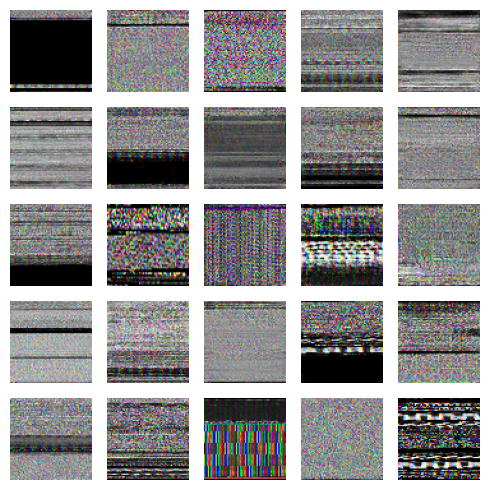

Epoch 2001/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9340 - g_loss: -8.2739 - kid: 0.0086
Epoch 2002/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.8775 - g_loss: -4.2957 - kid: 0.0082
Epoch 2003/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.8665 - g_loss: -5.0004 - kid: 0.0086
Epoch 2004/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.1091 - g_loss: -5.2681 - kid: 0.0083
Epoch 2005/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.8374 - g_loss: -6.7775 - kid: 0.0083
Epoch 2006/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9035 - g_loss: -7.7381 - kid: 0.0082
Epoch 2007/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9663 - g_loss: -6.3796 - kid: 0.0081
Epoch 2008/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9491 - g_loss: -6.2609 - kid: 0.0086
Epoch 2009/2500
49/49 [=========================

49/49 [==============================] - 62s 1s/step - d_loss: -6.8013 - g_loss: -6.1291 - kid: 0.0091
Epoch 2070/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9774 - g_loss: -5.6549 - kid: 0.0086
Epoch 2071/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.7920 - g_loss: -5.5269 - kid: 0.0083
Epoch 2072/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.8101 - g_loss: -5.3777 - kid: 0.0088
Epoch 2073/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.7987 - g_loss: -7.3814 - kid: 0.0084
Epoch 2074/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9637 - g_loss: -5.8525 - kid: 0.0083
Epoch 2075/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9263 - g_loss: -7.5337 - kid: 0.0091
Epoch 2076/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9065 - g_loss: -7.2361 - kid: 0.0090
Epoch 2077/2500
49/49 [==============================] - 62s 1s/

Epoch 2138/2500
49/49 [==============================] - 62s 1s/step - d_loss: -7.0313 - g_loss: -8.8710 - kid: 0.0085
Epoch 2139/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9621 - g_loss: -8.9719 - kid: 0.0085
Epoch 2140/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.8138 - g_loss: -7.7746 - kid: 0.0088
Epoch 2141/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9597 - g_loss: -6.8198 - kid: 0.0089
Epoch 2142/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.8768 - g_loss: -7.5957 - kid: 0.0087
Epoch 2143/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9434 - g_loss: -5.7168 - kid: 0.0089
Epoch 2144/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9882 - g_loss: -3.9950 - kid: 0.0087
Epoch 2145/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9774 - g_loss: -5.6182 - kid: 0.0086
Epoch 2146/2500
49/49 [=========================

49/49 [==============================] - 62s 1s/step - d_loss: -6.8369 - g_loss: -8.3311 - kid: 0.0083
Epoch 2207/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.8691 - g_loss: -8.1441 - kid: 0.0083
Epoch 2208/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.8414 - g_loss: -8.4344 - kid: 0.0087
Epoch 2209/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.8790 - g_loss: -7.1138 - kid: 0.0089
Epoch 2210/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.7482 - g_loss: -6.9122 - kid: 0.0087
Epoch 2211/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9326 - g_loss: -8.3568 - kid: 0.0084
Epoch 2212/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.7920 - g_loss: -8.6444 - kid: 0.0080
Epoch 2213/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9188 - g_loss: -9.7443 - kid: 0.0077
Epoch 2214/2500
49/49 [==============================] - 62s 1s/

Epoch 2275/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.6498 - g_loss: -7.7061 - kid: 0.0083
Epoch 2276/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.7924 - g_loss: -7.7292 - kid: 0.0080
Epoch 2277/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9490 - g_loss: -7.6908 - kid: 0.0083
Epoch 2278/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.7837 - g_loss: -8.2113 - kid: 0.0082
Epoch 2279/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.8579 - g_loss: -6.7082 - kid: 0.0084
Epoch 2280/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.9664 - g_loss: -6.2708 - kid: 0.0087
Epoch 2281/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.8203 - g_loss: -8.1170 - kid: 0.0084
Epoch 2282/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.8203 - g_loss: -6.8348 - kid: 0.0084
Epoch 2283/2500
49/49 [=========================

49/49 [==============================] - 62s 1s/step - d_loss: -6.7434 - g_loss: -7.6803 - kid: 0.0080
Epoch 2344/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.6659 - g_loss: -7.9428 - kid: 0.0079
Epoch 2345/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.7356 - g_loss: -6.2220 - kid: 0.0078
Epoch 2346/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.8103 - g_loss: -7.1038 - kid: 0.0080
Epoch 2347/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.6560 - g_loss: -5.4521 - kid: 0.0076
Epoch 2348/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.7424 - g_loss: -6.0240 - kid: 0.0081
Epoch 2349/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.5395 - g_loss: -5.7793 - kid: 0.0079
Epoch 2350/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.8283 - g_loss: -7.0047 - kid: 0.0078
Epoch 2351/2500
49/49 [==============================] - 62s 1s/

49/49 [==============================] - 62s 1s/step - d_loss: -6.8370 - g_loss: -6.9806 - kid: 0.0090
Epoch 2412/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.7707 - g_loss: -5.6974 - kid: 0.0079
Epoch 2413/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.6264 - g_loss: -6.7978 - kid: 0.0085
Epoch 2414/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.7330 - g_loss: -6.4255 - kid: 0.0084
Epoch 2415/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.7473 - g_loss: -8.0125 - kid: 0.0083
Epoch 2416/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.8553 - g_loss: -7.9354 - kid: 0.0080
Epoch 2417/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.7300 - g_loss: -7.2036 - kid: 0.0077
Epoch 2418/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.8560 - g_loss: -7.8309 - kid: 0.0087
Epoch 2419/2500
49/49 [==============================] - 62s 1s/

49/49 [==============================] - 62s 1s/step - d_loss: -6.8194 - g_loss: -9.9849 - kid: 0.0085
Epoch 2480/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.6764 - g_loss: -7.8894 - kid: 0.0084
Epoch 2481/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.6832 - g_loss: -7.2488 - kid: 0.0086
Epoch 2482/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.5745 - g_loss: -8.2910 - kid: 0.0078
Epoch 2483/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.6506 - g_loss: -7.0283 - kid: 0.0084
Epoch 2484/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.8377 - g_loss: -5.9080 - kid: 0.0084
Epoch 2485/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.7386 - g_loss: -5.4759 - kid: 0.0086
Epoch 2486/2500
49/49 [==============================] - 62s 1s/step - d_loss: -6.6012 - g_loss: -8.4573 - kid: 0.0084
Epoch 2487/2500
49/49 [==============================] - 62s 1s/

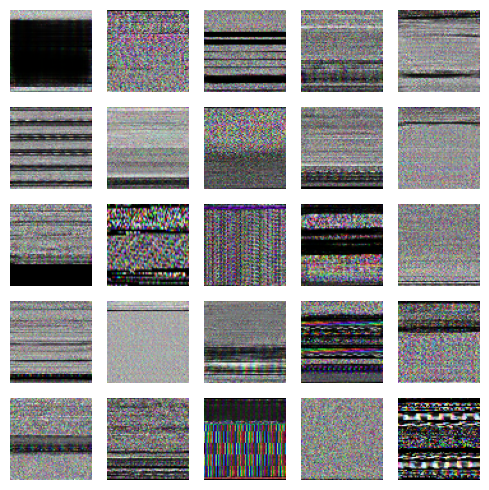

Training time: 18:48:02


In [13]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

# Get the wgan model
wgan = WGAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=latent_dim,
    discriminator_extra_steps=5,
)

# Compile the wgan model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)        

# Start training
tic = time.time()
history = wgan.fit(train_ds, epochs=2500, callbacks=[keras.callbacks.LambdaCallback(on_epoch_end=wgan.plot_images)])
print("Training time:", time.strftime("%H:%M:%S", time.gmtime(time.time() - tic)))

## Plotting generator and discriminator losses

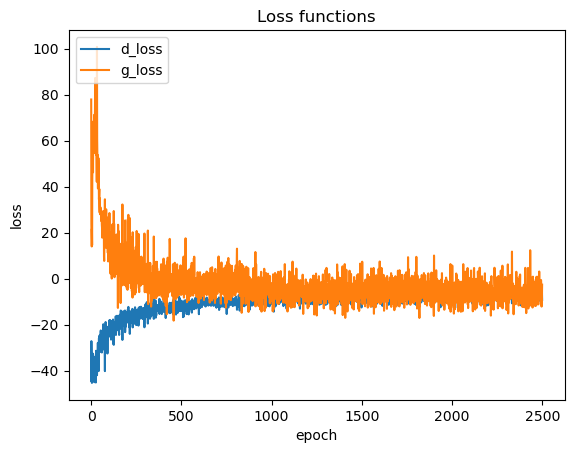

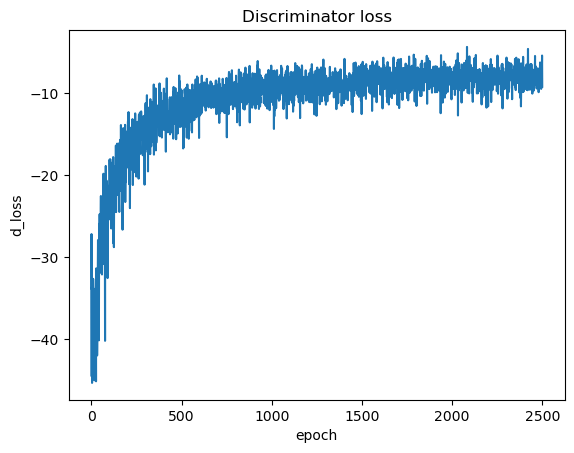

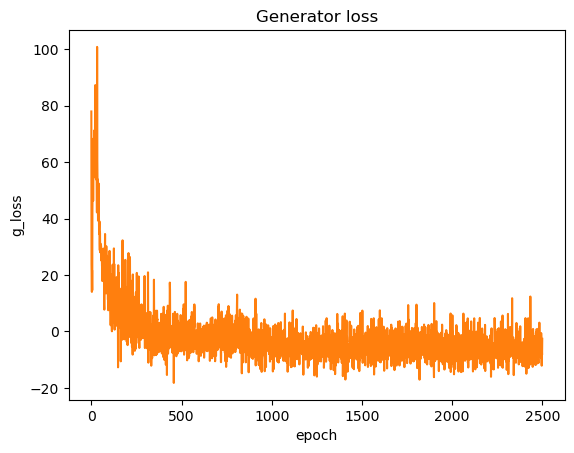

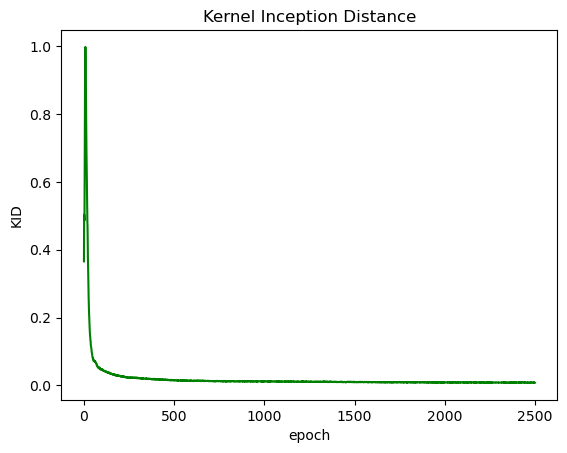

In [14]:
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'])
plt.title('Loss functions')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['d_loss', 'g_loss'], loc='upper left')
plt.show()

plt.plot(history.history['d_loss'])
plt.title('Discriminator loss')
plt.ylabel('d_loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['g_loss'], color='C1')
plt.title('Generator loss')
plt.ylabel('g_loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['kid'], color='green')
plt.title('Kernel Inception Distance')
plt.ylabel('KID')
plt.xlabel('epoch')
plt.show()

## Generating fake images

In [17]:
num_imgs=500
for j in range(num_classes):
    for i in range(num_imgs):
        label = tf.one_hot([j], num_classes)
        latent_vector = tf.random.normal(shape=(1, latent_dim))
        noise_label = tf.concat([latent_vector, label], 1)
        image = wgan.generator(noise_label, training=False)
        image = (image * 127.5) + 127.5
        image = image[0].numpy()
        image = keras.preprocessing.image.array_to_img(image)
        
        plt.figure(figsize=(1,1))
        plt.axis("off")
        plt.imshow(image)
        plt.savefig('fake-malevis-2/{}/fake_{}.png'.format(j, i+1), bbox_inches='tight', pad_inches=0)
        plt.close()

In [16]:
num_imgs=500
for j in range(num_classes):
    for i in range(num_imgs):
        label = tf.one_hot([j], num_classes)
        latent_vector = tf.random.normal(shape=(1, latent_dim))
        noise_label = tf.concat([latent_vector, label], 1)
        image = wgan.generator(noise_label, training=False)
        image = (image * 127.5) + 127.5
        image = image[0].numpy()
        image = keras.preprocessing.image.array_to_img(image)
        
        plt.figure(figsize=(1,1))
        plt.axis("off")
        plt.imshow(image)
        plt.savefig('aug-malevis/{}/fake_{}.png'.format(j, i+1), bbox_inches='tight', pad_inches=0)
        plt.close()